# House Prices – Top 10 Feature Engineering Tricks 🏠

**Competition:** House Prices: Advanced Regression Techniques  
**Link:** https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In this notebook, we focus on **feature engineering and model comparison**, not hardcore ensembling.

We specifically highlight:

1. Log-transform of target (`SalePrice`)
2. Skew correction of numeric features
3. Missing value strategies for numeric/categorical
4. Rare category grouping
5. One-Hot Encoding
6. Target Encoding
7. Scaling numeric features
8. Cross-validation with RMSE
9. Model comparison (Lasso / RandomForest / GradientBoosting)
10. Error analysis (residual plots + worst predictions)

We'll compare **One-Hot vs Target Encoding** and analyze where the model struggles.

In [1]:
!pip install -q category_encoders

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import category_encoders as ce

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import FeatureUnion

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid")

In [2]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test  = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

print("Train shape:", train.shape)
print("Test shape :", test.shape)

train.head()

Train shape: (1460, 81)
Test shape : (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Target & ID Handling + Concatenate Train/Test

We will:

- Separate `SalePrice` as target.
- Log-transform `SalePrice` for more Gaussian-like distribution.
- Drop `Id` from features but keep it for the final submission.
- Concatenate train & test features for consistent preprocessing.

In [3]:
# Save Id for later
train_id = train["Id"]
test_id  = test["Id"]

# Drop Id
train = train.drop("Id", axis=1)
test  = test.drop("Id", axis=1)

# Target
y = np.log1p(train["SalePrice"])  # Trick #1: log-transform target
X = train.drop("SalePrice", axis=1)

# Concatenate features
full = pd.concat([X, test], axis=0, ignore_index=True)
print("Full data shape:", full.shape)

Full data shape: (2919, 79)


## Explore feature types

We'll detect:

- Numeric features
- Categorical features

Using dtypes.


In [4]:
numeric_features = full.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = full.select_dtypes(include=["object"]).columns.tolist()

print("Number of numeric features    :", len(numeric_features))
print("Number of categorical features:", len(categorical_features))

numeric_features[:10], categorical_features[:10]

Number of numeric features    : 36
Number of categorical features: 43


(['MSSubClass',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'MasVnrArea',
  'BsmtFinSF1',
  'BsmtFinSF2'],
 ['MSZoning',
  'Street',
  'Alley',
  'LotShape',
  'LandContour',
  'Utilities',
  'LotConfig',
  'LandSlope',
  'Neighborhood',
  'Condition1'])

## Skew Correction for Numeric Features

Trick #2 and #3:

- Compute skewness on numeric features (train only).
- Log1p-transform features with high skew (> 0.75).

This helps tree models and linear models by reducing the effect of extreme values.

In [6]:
numeric_train = full.loc[: len(X) - 1, numeric_features]

skewness = numeric_train.apply(lambda x: skew(x.dropna()))
skewed_feats = skewness[skewness > 0.75].index.tolist()

print("Number of skewed numeric features:", len(skewed_feats))
print("Sample skewed features:", skewed_feats[:15])

# Apply log1p to skewed features
full[skewed_feats] = np.log1p(full[skewed_feats])

Number of skewed numeric features: 21
Sample skewed features: ['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF']


/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


## Handling Rare Categories

Trick #4: Group **rare categories** into a single `"RARE"` label.

This reduces noise and helps models generalize better, especially for Target Encoding.

In [7]:
def reduce_rare_categories(df, cols, min_freq=10):
    df = df.copy()
    for col in cols:
        freq = df[col].value_counts()
        rare_labels = freq[freq < min_freq].index
        df[col] = df[col].replace(rare_labels, "RARE")
    return df

full[categorical_features] = reduce_rare_categories(full[categorical_features],
                                                    categorical_features,
                                                    min_freq=10)

In [8]:
X_processed = full.iloc[: len(X), :].copy()
test_processed = full.iloc[len(X):, :].copy()

print("Train features shape:", X_processed.shape)
print("Test  features shape:", test_processed.shape)

Train features shape: (1460, 79)
Test  features shape: (1459, 79)


## Preprocessing Pipelines

We'll build:

1. **One-Hot Encoding pipeline**
   - Impute numeric with median
   - Impute categorical with mode
   - Scale numeric
   - One-Hot encode categoricals

2. **Target Encoding pipeline**
   - Numeric: impute + scale
   - Categorical: TargetEncoder with `SalePrice`

This lets us compare **One-Hot vs Target Encoding** fairly.

In [9]:
numeric_transformer_ohe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())  # Trick #7: scaling numeric
])

categorical_transformer_ohe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))  # Trick #5: OHE
])

preprocessor_ohe = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_ohe, numeric_features),
        ("cat", categorical_transformer_ohe, categorical_features)
    ]
)

In [10]:
class NumericSelector(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.pipe = clone(Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]))

    def fit(self, X, y=None):
        self.pipe.fit(X[self.cols], y)
        return self

    def transform(self, X):
        return self.pipe.transform(X[self.cols])


class CategoricalTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = ce.TargetEncoder(cols=self.cols)  # Trick #6: Target Encoding

    def fit(self, X, y):
        self.encoder.fit(X[self.cols], y)
        return self

    def transform(self, X):
        return self.encoder.transform(X[self.cols]).values


def build_target_encoding_pipeline(base_model):
    features_union = FeatureUnion(transformer_list=[
        ("num", NumericSelector(numeric_features)),
        ("cat", CategoricalTargetEncoder(categorical_features))
    ])

    model_pipeline = Pipeline(steps=[
        ("features", features_union),
        ("model", base_model)
    ])

    return model_pipeline

## Cross-Validation & RMSE

Trick #8: Use **K-Fold cross-validation** with **RMSE** on the log-transformed target.

We'll create a helper function to evaluate models consistently.

In [11]:
def rmse_cv(model, X, y, preprocessor=None, use_target_encoding=False):
    """
    Compute cross-validated RMSE (lower is better).
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    if use_target_encoding:
        pipeline = build_target_encoding_pipeline(model)
    else:
        pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", model)
        ])

    neg_mse_scores = cross_val_score(
        pipeline,
        X,
        y,
        scoring="neg_mean_squared_error",
        cv=kf
    )
    rmse_scores = np.sqrt(-neg_mse_scores)
    return rmse_scores

## Models for Comparison

Trick #9: Compare multiple models + encodings:

- Lasso (linear, L1 regularization)
- RandomForestRegressor
- GradientBoostingRegressor

Each with:
- One-Hot Encoding
- Target Encoding (for some)

In [12]:
models = {
    "Lasso (OHE)": {
        "model": Lasso(alpha=0.0005, random_state=RANDOM_STATE),
        "preprocessor": preprocessor_ohe,
        "use_target_encoding": False
    },
    "RandomForest (OHE)": {
        "model": RandomForestRegressor(
            n_estimators=300,
            max_depth=None,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        "preprocessor": preprocessor_ohe,
        "use_target_encoding": False
    },
    "GBR (OHE)": {
        "model": GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=RANDOM_STATE
        ),
        "preprocessor": preprocessor_ohe,
        "use_target_encoding": False
    },
    "Lasso (TargetEnc)": {
        "model": Lasso(alpha=0.0005, random_state=RANDOM_STATE),
        "preprocessor": None,
        "use_target_encoding": True
    },
    "RandomForest (TargetEnc)": {
        "model": RandomForestRegressor(
            n_estimators=300,
            max_depth=None,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        "preprocessor": None,
        "use_target_encoding": True
    }
}

In [13]:
results = []

for name, cfg in models.items():
    print(f"Training: {name}")
    scores = rmse_cv(
        model=cfg["model"],
        X=X_processed,
        y=y,
        preprocessor=cfg["preprocessor"],
        use_target_encoding=cfg["use_target_encoding"]
    )
    print(f"  RMSE: {scores.mean():.5f} (+/- {scores.std():.5f})")
    results.append({
        "Model": name,
        "CV_RMSE_Mean": scores.mean(),
        "CV_RMSE_Std": scores.std()
    })

results_df = pd.DataFrame(results).sort_values("CV_RMSE_Mean")
results_df.reset_index(drop=True, inplace=True)
results_df


Training: Lasso (OHE)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

  RMSE: 0.12871 (+/- 0.02089)
Training: RandomForest (OHE)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

  RMSE: 0.14437 (+/- 0.01887)
Training: GBR (OHE)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

  RMSE: 0.13072 (+/- 0.02171)
Training: Lasso (TargetEnc)
  RMSE: 0.13299 (+/- 0.01906)
Training: RandomForest (TargetEnc)
  RMSE: 0.14185 (+/- 0.01700)


,Model,CV_RMSE_Mean,CV_RMSE_Std
0,Lasso (OHE),0.128710,0.020893
1,GBR (OHE),0.130721,0.021709
2,Lasso (TargetEnc),0.132988,0.019059
3,RandomForest (TargetEnc),0.141848,0.016999
4,RandomForest (OHE),0.144371,0.018871


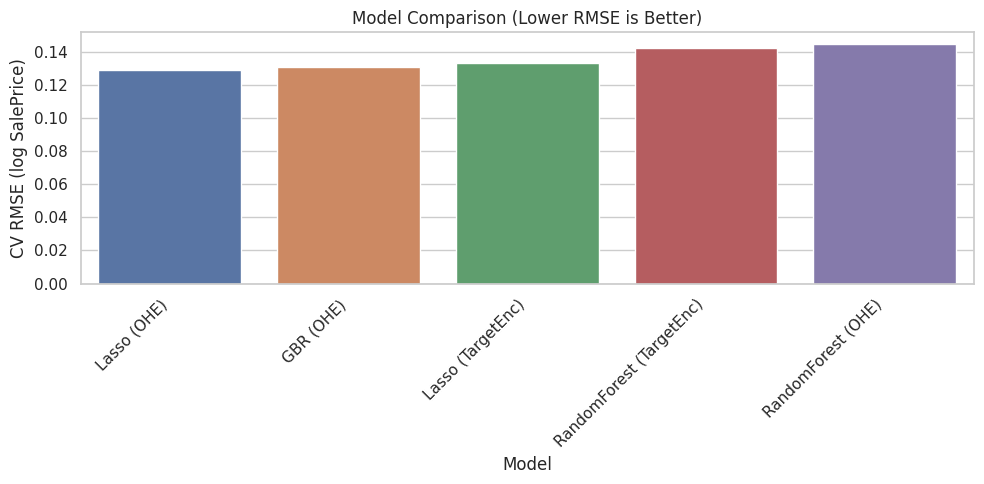

In [14]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=results_df,
    x="Model",
    y="CV_RMSE_Mean"
)
plt.xticks(rotation=45, ha="right")
plt.title("Model Comparison (Lower RMSE is Better)")
plt.ylabel("CV RMSE (log SalePrice)")
plt.tight_layout()
plt.show()

## Train Final Model

Trick #10: Pick the best model from CV results and train it on the full training data.

In [15]:
# Choose best model based on results_df output
best_model_name = results_df.loc[0, "Model"]
print("Best model from CV:", best_model_name)

cfg = models[best_model_name]

if cfg["use_target_encoding"]:
    final_pipeline = build_target_encoding_pipeline(cfg["model"])
else:
    final_pipeline = Pipeline(steps=[
        ("preprocessor", cfg["preprocessor"]),
        ("model", cfg["model"])
    ])

final_pipeline.fit(X_processed, y)

# Predictions on train for error analysis
y_pred_train_log = final_pipeline.predict(X_processed)
y_pred_train = np.expm1(y_pred_train_log)
y_true_train = np.expm1(y)

rmse_full = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
print(f"Full train RMSE (SalePrice): {rmse_full:.2f}")


Best model from CV: Lasso (OHE)
Full train RMSE (SalePrice): 24833.01


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Error Analysis

We'll look at:

- Distribution of residuals
- Residuals vs predicted values
- Top 10 worst predictions (by absolute error)

This is great to show in your Kaggle notebook discussion.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


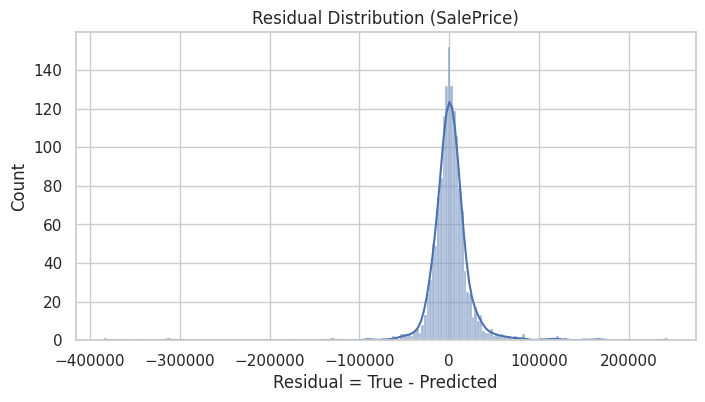

In [16]:
residuals = y_true_train - y_pred_train

plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (SalePrice)")
plt.xlabel("Residual = True - Predicted")
plt.show()

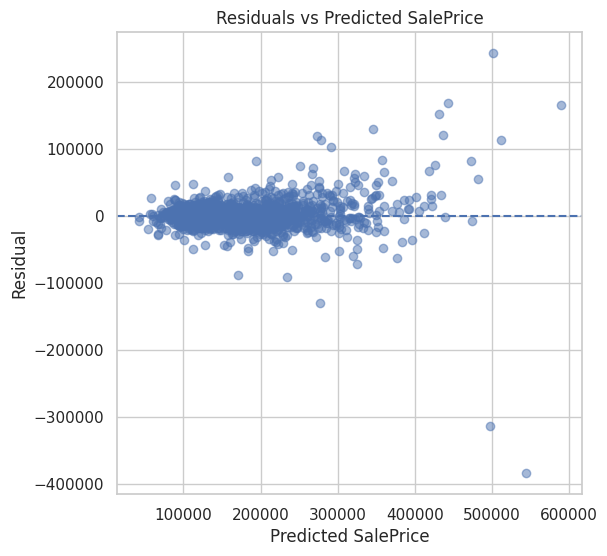

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(y_pred_train, residuals, alpha=0.5)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted SalePrice")
plt.show()

In [18]:
error_df = pd.DataFrame({
    "Id": train_id,
    "SalePrice_true": y_true_train,
    "SalePrice_pred": y_pred_train,
    "Residual": residuals
})
error_df["AbsError"] = error_df["Residual"].abs()

worst_errors = error_df.sort_values("AbsError", ascending=False).head(10)
worst_errors

,Id,SalePrice_true,SalePrice_pred,Residual,AbsError
1298,1299,160000.0,544552.559603,-384552.559603,384552.559603
523,524,184750.0,498308.130203,-313558.130203,313558.130203
1182,1183,745000.0,502170.036232,242829.963768,242829.963768
898,899,611657.0,443663.178025,167993.821975,167993.821975
691,692,755000.0,590125.310775,164874.689225,164874.689225
803,804,582933.0,431561.283575,151371.716425,151371.716425
1324,1325,147000.0,277376.207666,-130376.207666,130376.207666
185,186,475000.0,345580.996879,129419.003121,129419.003121
1046,1047,556581.0,436431.984780,120149.015220,120149.015220
688,689,392000.0,272864.571229,119135.428771,119135.428771


In [19]:
test_preds_log = final_pipeline.predict(test_processed)
test_preds = np.expm1(test_preds_log)

submission = pd.DataFrame({
    "Id": test_id,
    "SalePrice": test_preds
})

submission.to_csv("submission_top10_feature_engineering.csv", index=False)
submission.head()

,Id,SalePrice
0,1461,117349.681561
1,1462,151278.755850
2,1463,179736.764949
3,1464,196085.014202
4,1465,203530.246889


## Conclusion

In this notebook, we:

- Applied **10 feature engineering tricks**:
  1. Log-transform target (`SalePrice`)
  2. Skew correction on numeric features
  3. Robust numeric imputation (median)
  4. Categorical imputation (most frequent)
  5. Rare category grouping
  6. One-Hot Encoding
  7. Target Encoding
  8. Scaling numeric features
  9. Cross-validated model comparison
  10. Error analysis (residuals + worst predictions)

We also compared **One-Hot vs Target Encoding** across multiple models and selected the best one based on CV RMSE.

Feel free to:
- Add more models (XGBoost, LightGBM, CatBoost)
- Tune hyperparameters
- Perform more detailed feature engineering